In [1]:
!pip install tensorflow==2.19.0

In [5]:
!pip install opencv-python


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
    --------------------------------------- 0.8/39.0 MB 5.6 MB/s eta 0:00:07
   -- ------------------------------------- 2.4/39.0 MB 7.1 MB/s eta 0:00:06
   ---- ----------------------------------- 4.2/39.0 MB 7.6 MB/s eta 0:00:05
   ----- ---------------------------------- 5.5/39.0 MB 7.1 MB/s eta 0:00:05
   ------- -------------------------------- 7.3/39.0 MB 7.7 MB/s eta 0:00:05
   --------- ------------------------------ 9.4/39.0 MB 8.0 MB/s eta 0:00:04
   ----------- ---------------------------- 11.5/39.0 MB 8.4 MB/s eta 0:00:04
   ------------- -------------------------- 13.4/39.0 MB 8.4 MB/s eta 0:00:04
   --------------- ------------------------ 15.5/39.0 MB 8.5 MB/s eta 0:00:03
   ----------------- ---------------------- 17.3/39.0 MB 8.6 MB/s eta 0:00:03
   ------------------- -------------------- 19.1/39.0 MB 8.6 MB/s eta 0:00:03
   --------------------- ------------------ 20.7/39.0 MB 8.4 MB/s eta 0:00:03


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
darts 0.34.0 requires numpy<2.0.0,>=1.19.0, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is incompatible.
gluonts 0.16.1 requires numpy<2.2,>=1.16, but you have numpy 2.2.6 which is incompatible.
llama-index-core 0.12.27 requires nltk>3.8.1, but you have nltk 3.8.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, but you have ml-dtypes 0.5.1 whic

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

In [9]:
model = tf.keras.models.load_model("C:/Users/HP/Desktop/ML_DS/CNN/notebooks/augmented_model/best_model.h5")
image_dir = "C:/Users/HP/Desktop/ML_DS/CNN/data/oxford-iiit-pet/images/images"
label_file = "C:/Users/HP/Desktop/ML_DS/CNN/data/oxford-iiit-pet/annotations/annotations/list.txt"

In [ ]:
last_conv_layer_name = "top_conv"
img_size = (224, 224)

def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return tf.keras.applications.efficientnet.preprocess_input(array)


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = heatmap_color * alpha + img
    cv2.imwrite(cam_path, superimposed[:, :, ::-1])

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed.astype("uint8"), cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


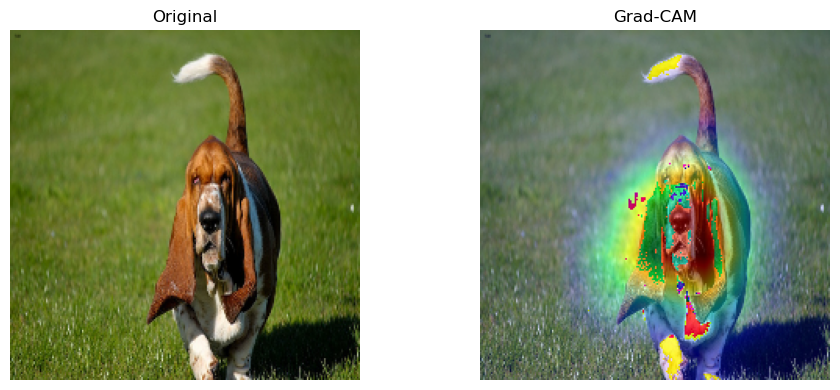

In [16]:
image_dir_sample = "C:/Users/HP/Desktop/ML_DS/CNN/data/oxford-iiit-pet/images/images/basset_hound_62.jpg"
img_array = get_img_array(image_dir_sample, img_size)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(image_dir_sample, heatmap)

In [22]:
import os 
import tqdm

In [25]:
root_path = "C:/Users/HP/Desktop/ML_DS/CNN/src/misclassified/"
output_path = "C:/Users/HP/Desktop/ML_DS/CNN/src/gradcam_misclassified/"
os.makedirs(output_path, exist_ok=True)

for filename in (os.listdir(root_path)):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(root_path, filename)
        
        try:
            img_array = get_img_array(img_path, (224, 224))
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv")
            
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

            save_path = os.path.join(output_path, f"gradcam_{filename}")
            cv2.imwrite(save_path, superimposed_img)

        except Exception as e:
            print(f"Failed for {filename} — {e}")



c:\Users\HP\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [26]:
root_path = "C:/Users/HP/Desktop/ML_DS/CNN/src/misclassified_augmented_model/"
output_path = "C:/Users/HP/Desktop/ML_DS/CNN/src/gradcam_misclassified_augmented_model/"
os.makedirs(output_path, exist_ok=True)

for filename in (os.listdir(root_path)):    
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(root_path, filename)
        
        try:
            img_array = get_img_array(img_path, (224, 224))
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv")
            
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
            superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

            save_path = os.path.join(output_path, f"gradcam_{filename}")
            cv2.imwrite(save_path, superimposed_img)

        except Exception as e:
            print(f"Failed for {filename} — {e}")